In [8]:
import torch
import numpy as np
import tritrain
import mapping
import matplotlib.pyplot as plt
from dataset import read_all_of_huaweicup, tensor_file_name_converter

## 不同轮次的输入数据可放在不同文件夹中便于管理，这里用户可以自定义
PathSet = {0: "./Test", 1: "./CompetitionData1", 2: "./CompetitionData2", 3: "./CompetitionData3"}
PrefixSet = {0: "Round0", 1: "Round1", 2: "Round2", 3: "Round3"}

Ridx = 1 # 设置比赛轮次索引，指明数据存放目录。0:Test; 1: 1st round; 2: 2nd round ...
Didx = 1 # 设置为第几组数据

PathRaw = PathSet[Ridx]
Prefix = PrefixSet[Ridx]


In [9]:
# 网络给出的嵌入向量为 64 和 anch_pos

embedding_dim = 64
bs_pos, tol_samp_num, anch_samp_num, port_num, ant_num, sc_num, anch_pos, H, d_geo = read_all_of_huaweicup(1, 1)

H_real = H.real
H_imag = H.imag
H_combined = np.stack((H_real, H_imag), axis=2)
H_combined = H_combined.reshape(tol_samp_num, 4, ant_num, sc_num)


Processing Round 1 Case 1
Loading configuration data file
Loading input position file
Loading input CSI data of Case 1
Loading Channel CSI succeed
Channel GEO data not exist


Model loaded from ./CompetitionData1/Round1NET11721400377.7985215.pth
Start mapping embeddings to coords through CVX toolbox
Known indices: [ 2  8 20 62 71]
Known embeddings (first 5): [[ 2.06038415e-01  4.15348038e-02 -2.42042933e-02 -2.39331305e-01
   9.45243299e-01 -2.62332946e-01  8.66816193e-03 -1.70277506e-01
   5.15783243e-02 -1.27234802e-01 -5.33703715e-02 -1.58629745e-01
   1.91384941e-01 -8.38187635e-01 -9.83277559e-02  2.73203012e-02
  -2.11455766e-02 -9.02052969e-02  3.01799595e-01 -2.30936185e-01
   1.48544550e-01  2.20280170e-01 -2.47593701e-01  7.05078959e-01
  -2.55453996e-02 -5.28101444e-01 -8.07938576e-02  9.30621624e-01
   2.72529364e-01 -2.51842678e-01 -7.96128362e-02 -6.69714510e-02
  -6.88070357e-01 -1.24023594e-01  1.92957059e-01 -7.15755224e-02
   2.90163040e-01  6.07996345e-01  2.55991608e-01 -5.74391782e-01
  -2.06975520e-01 -1.08922228e-01  1.89703684e-02 -1.19525522e-01
  -2.77138650e-01 -8.18977505e-02 -7.51275659e-01  2.75060922e-01
   1.24824643e-01  5.98

UsageError: Line magic function `%` not found.


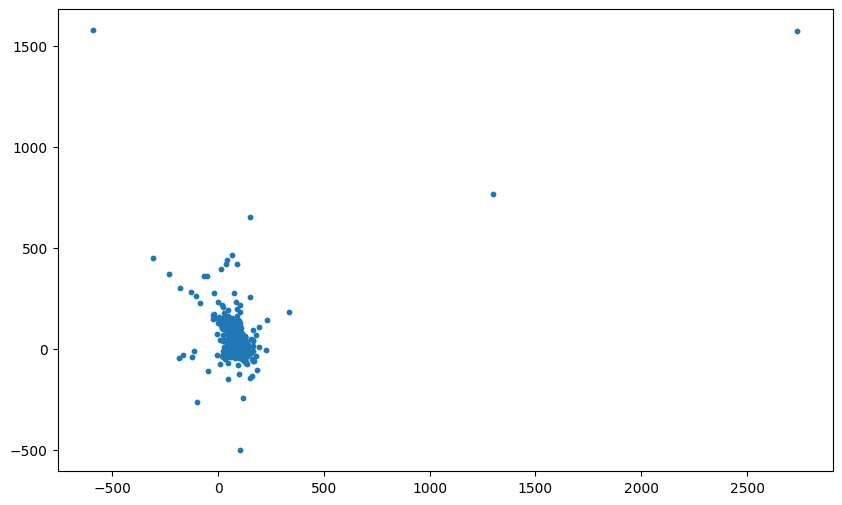

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_file = './CompetitionData1/Round1NET11721400377.7985215.pth'
# 在需要使用模型的地方加载模型
triplet_net_loaded = tritrain.TripletNet().to(device)
triplet_net_loaded.load_state_dict(torch.load(model_file))
triplet_net_loaded.eval()  # 切换到评估模式

print("Model loaded from "+model_file)
embeddings = mapping.map_embeddings(triplet_net_loaded, H_combined, device)

# 调用函数
mapped_coords = mapping.map_embeddings_to_coords(embeddings, anch_pos)

# 输出前五个映射结果
print("Mapped Coordinates for the first 5 points:")
print(mapped_coords[:5])

# 验证转换效果
if mapped_coords is not None:
    print("Original Known Coordinates:")
    print(anch_pos[:5, 1:])
    print("Mapped Coordinates for Known Embeddings:")
    mapped_known_coords = mapped_coords[anch_pos[:5, 0].astype(int)]
    print(mapped_known_coords[:5])
    # 绘制结果
    plt.figure(figsize=(10, 6))
    plt.scatter(mapped_coords[:, 0], mapped_coords[:, 1], s=10, label='Mapped Points')
    % plt.scatter(anch_pos[:, 1], anch_pos[:, 2], s=50, label='Anchor Points', marker='x')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Mapped Coordinates vs Anchor Points')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 计算误差差值
    indices = anch_pos[:, 0].astype(int)
    real_coords = anch_pos[:, 1:]
    diff = mapped_coords[indices] - real_coords
    # 计算所有锚点偏差的总和
    total_diff_sum = np.sum(np.abs(diff))  # 可以改为 np.linalg.norm(diff) 求范数
    # 打印结果
    print("Differences between Mapped and Real Coordinates:",diff[:5])
    print("Total deviation of anchor points:", total_diff_sum)


    # 回填锚点位置信息
    for idx in range(anch_samp_num):
        rowIdx = int(anch_pos[idx][0] - 1)
        mapped_coords[rowIdx] = np.array([anch_pos[idx][1], anch_pos[idx][2]])

    # 输出结果：各位参赛者注意输出值的精度
    print('Writing output position file')
    with open(PathRaw + '/' + Prefix + 'OutputPos' + str(Didx) + '.txt', 'w') as f:
        np.savetxt(f, mapped_coords, fmt='%.4f %.4f')

else:
    print("Mapping failed.")
